In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest , chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('speech.csv')

In [6]:
df.shape

(756, 755)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [8]:
df.describe

<bound method NDFrame.describe of       id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0      0       1  0.85247  0.71826  0.57227        240               239   
1      0       1  0.76686  0.69481  0.53966        234               233   
2      0       1  0.85083  0.67604  0.58982        232               231   
3      1       0  0.41121  0.79672  0.59257        178               177   
4      1       0  0.32790  0.79782  0.53028        236               235   
..   ...     ...      ...      ...      ...        ...               ...   
751  250       0  0.80903  0.56355  0.28385        417               416   
752  250       0  0.16084  0.56499  0.59194        415               413   
753  251       0  0.88389  0.72335  0.46815        381               380   
754  251       0  0.83782  0.74890  0.49823        340               339   
755  251       0  0.81304  0.76471  0.46374        340               339   

     meanPeriodPulses  stdDevPeriodPulses  locPctJitt

In [9]:
df = df.groupby('id').mean().reset_index()
df.drop('id',axis=1, inplace=True)

In [11]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue
    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])

        if val >0.7:

            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    df = df[filtered_columns]
df.shape

(252, 287)

In [13]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

In [14]:
df.describe

<bound method NDFrame.describe of      gender       DFA          f1  VFER_mean  IMF_SNR_SEO  mean_MFCC_2nd_coef  \
0       1.0  0.696370  550.716984   0.000479    45.251033            2.868933   
1       0.0  0.793993  832.920994   0.000253    82.136333            2.909100   
2       1.0  0.619967  683.269240   0.001704    13.799367           -0.431677   
3       0.0  0.626097  712.242460   0.003726     0.417453            0.497686   
4       0.0  0.779397  504.376144   0.001358    39.001700            3.326100   
..      ...       ...         ...        ...          ...                 ...   
247     0.0  0.651830  705.192316   0.001110    28.754167            0.933697   
248     1.0  0.688327  654.991006   0.000921    15.672333            1.496493   
249     1.0  0.788800  443.565702   0.000107    76.918567            1.773467   
250     0.0  0.569010  907.148124   0.008256     3.266500           -1.738833   
251     0.0  0.745653  721.853906   0.000103    53.132900           -0.2011

<function matplotlib.pyplot.show(close=None, block=None)>

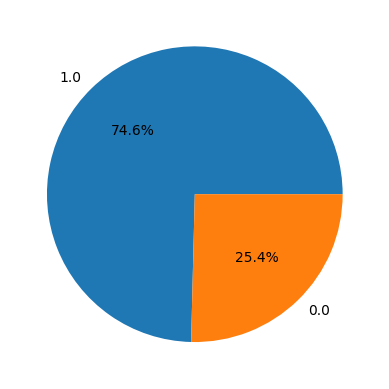

In [15]:
#checking for the balance of the dataset

x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct = '%1.1f%%')
plt.show

In [17]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size = 0.2,
                                      random_state=10)
X_train.shape, X_val.shape

((201, 30), (51, 30))

In [18]:
#balancing the data as its is highly imbalanced by adding repetitive rows of minority class
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=0)
X,Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.shape

((302, 30), (302,))

In [25]:
from sklearn.metrics import roc_auc_score as ras
from xgboost import XGBClassifier
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for i in range(len(models)):
    models[i].fit(X,Y)

    print(f'{models[i]} : ')

    train_preds = models[i].predict_proba(X)[:, 1]
    print('Training Accuracy: ', ras(Y,train_preds))

    val_preds = models[i].predict_proba(X_val)[:, 1]
    print('Validation Accuracy: ', ras(Y_val, val_preds))
    print()

LogisticRegression() : 
Training Accuracy:  0.828954870400421
Validation Accuracy:  0.8088803088803088

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy:  1.0
Validation Accuracy:  0.7992277992277993

SVC(probability=True) : 
Training Accuracy:  0.7104074382702513
Valid

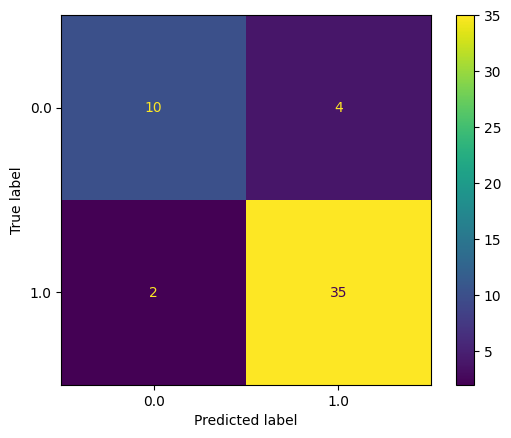

In [28]:
#confusion marix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(models[0],X_val, Y_val)
plt.show()

In [29]:
print(metrics.classification_report
      (Y_val, models[0].predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77        14
         1.0       0.90      0.95      0.92        37

    accuracy                           0.88        51
   macro avg       0.87      0.83      0.85        51
weighted avg       0.88      0.88      0.88        51

